# Customer Segmentation Using RFM and K-Means Clustering
 ## Research question
How can we segment retail customers based on their purchasing behavior to support targeted marketing and retention strategies?

## Data Loading

In [59]:
import pandas as pn

In [60]:
c = pn.read_csv("customer_data.csv")
s = pn.read_csv("sales_data.csv")

In [61]:
print(c.head())

  customer_id  gender   age payment_method
0     C241288  Female  28.0    Credit Card
1     C111565    Male  21.0     Debit Card
2     C266599    Male  20.0           Cash
3     C988172  Female  66.0    Credit Card
4     C189076  Female  53.0           Cash


In [62]:
print(s.head())

  invoice_no customer_id  category  quantity    price invoice_date  \
0    I138884     C241288  Clothing         5  1500.40   05-08-2022   
1    I317333     C111565     Shoes         3  1800.51   12-12-2021   
2    I127801     C266599  Clothing         1   300.08   09-11-2021   
3    I173702     C988172     Shoes         5  3000.85   16-05-2021   
4    I337046     C189076     Books         4    60.60   24-10-2021   

    shopping_mall  
0          Kanyon  
1  Forum Istanbul  
2       Metrocity  
3    Metropol AVM  
4          Kanyon  


## Data Description
- `customer_data.csv`: customer demographic & ID info
- `sales_data.csv`: transaction details (invoice, amount, date, etc.)

## Wrangling by sql

In [66]:
!pip install pandasql

In [67]:
from pandasql import sqldf
pysql = lambda q: sqldf(q, globals())

In [68]:
query = """
SELECT s.invoice_no,
    s.customer_id,
    c.gender,
    c.age,
    c.payment_method,
    s.category,
    s.quantity,
    s.price,
    s.invoice_date,
    s.shopping_mall
FROM s
JOIN c ON s.customer_id = c.customer_id"""

joined_df = pysql(query)
joined_df.head()

,invoice_no,customer_id,gender,age,payment_method,category,quantity,price,invoice_date,shopping_mall
0,I138884,C241288,Female,28.0,Credit Card,Clothing,5,1500.40,05-08-2022,Kanyon
1,I317333,C111565,Male,21.0,Debit Card,Shoes,3,1800.51,12-12-2021,Forum Istanbul
2,I127801,C266599,Male,20.0,Cash,Clothing,1,300.08,09-11-2021,Metrocity
3,I173702,C988172,Female,66.0,Credit Card,Shoes,5,3000.85,16-05-2021,Metropol AVM
4,I337046,C189076,Female,53.0,Cash,Books,4,60.60,24-10-2021,Kanyon


In [69]:
s['invoice_date'] = pn.to_datetime(s['invoice_date'], errors='coerce')
df = pn.merge(s, c, on='customer_id')
df.head()

,invoice_no,customer_id,category,quantity,price,invoice_date,shopping_mall,gender,age,payment_method
0,I138884,C241288,Clothing,5,1500.40,2022-05-08,Kanyon,Female,28.0,Credit Card
1,I317333,C111565,Shoes,3,1800.51,2021-12-12,Forum Istanbul,Male,21.0,Debit Card
2,I127801,C266599,Clothing,1,300.08,2021-09-11,Metrocity,Male,20.0,Cash
3,I173702,C988172,Shoes,5,3000.85,NaT,Metropol AVM,Female,66.0,Credit Card
4,I337046,C189076,Books,4,60.60,NaT,Kanyon,Female,53.0,Cash


In [70]:
latest_date = df['invoice_date'].max()

rfm = df.groupby('customer_id').agg({
    'invoice_date': lambda x: (latest_date - x.max()).days,  # R
    'invoice_no': 'nunique',                                  # F
    'price': 'sum'                                            # M
}).reset_index()

rfm.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']
rfm.head()

,customer_id,Recency,Frequency,Monetary
0,C100004,NaN,1,3000.80
1,C100005,274.0,1,2400.68
2,C100006,689.0,1,107.52
3,C100012,NaN,1,52.30
4,C100019,NaN,1,35.84


In [71]:
#Rating
rfm['R_score'] = pn.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
rfm['F_score'] = pn.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M_score'] = pn.qcut(rfm['Monetary'].rank(method='first'), 4, labels=[1, 2, 3, 4])

In [72]:
#Delete observation with missing value
rfm_clean = rfm.dropna(subset=['R_score', 'F_score', 'M_score'])

from sklearn.preprocessing import StandardScaler

#Scale the data
X = rfm_clean[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## K-means

In [73]:
#Using K-means
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
rfm_clean.loc[:, 'KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

/tmp/ipykernel_638/413230819.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_clean.loc[:, 'KMeans_Cluster'] = kmeans.fit_predict(X_scaled)


In [74]:
rfm_clean.groupby('KMeans_Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(1)

,Recency,Frequency,Monetary
KMeans_Cluster,,,
0,870.0,1.0,483.0
1,419.2,1.0,511.2
2,674.1,1.0,2891.0
3,653.8,1.0,7199.2


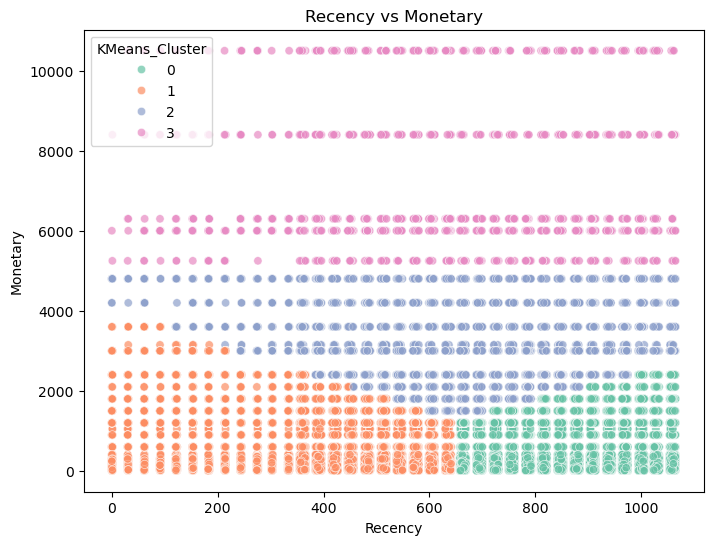

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=rfm_clean,
    x='Recency', y='Monetary',
    hue='KMeans_Cluster',
    palette='Set2',
    alpha=0.7
)
plt.title("Recency vs Monetary")
plt.xlabel("Recency")
plt.ylabel("Monetary")
plt.show()

/tmp/ipykernel_638/1571965161.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm_clean, x='KMeans_Cluster', palette='Set2')


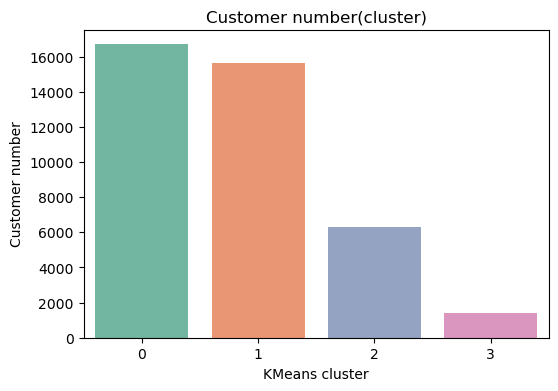

In [76]:
plt.figure(figsize=(6, 4))
sns.countplot(data=rfm_clean, x='KMeans_Cluster', palette='Set2')
plt.title("Customer number(cluster)")
plt.xlabel("KMeans cluster")
plt.ylabel("Customer number")
plt.show()

In [77]:
def label_segment(cluster):
    if cluster == 3:
        return "High Value Customer"
    elif cluster == 2:
        return "Mid-High Spending Customer"
    elif cluster == 1:
        return "Regular Customer"
    elif cluster == 0:
        return "Dormant Customer"
    else:
        return "Unknown"

rfm_clean.loc[:, 'Cluster_Label'] = rfm_clean['KMeans_Cluster'].apply(label_segment)

/tmp/ipykernel_638/1797907892.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_clean.loc[:, 'Cluster_Label'] = rfm_clean['KMeans_Cluster'].apply(label_segment)


In [78]:
rfm_clean['Cluster_Label'].value_counts()

Cluster_Label
Dormant Customer              16695
Regular Customer              15618
Mid-High Spending Customer     6324
High Value Customer            1392
Name: count, dtype: int64

In [79]:
rfm_clean[rfm_clean['Cluster_Label'] == "High Value Customer"][
    ['customer_id', 'Recency', 'Frequency', 'Monetary']
].to_csv("high_value_customers.csv", index=False)

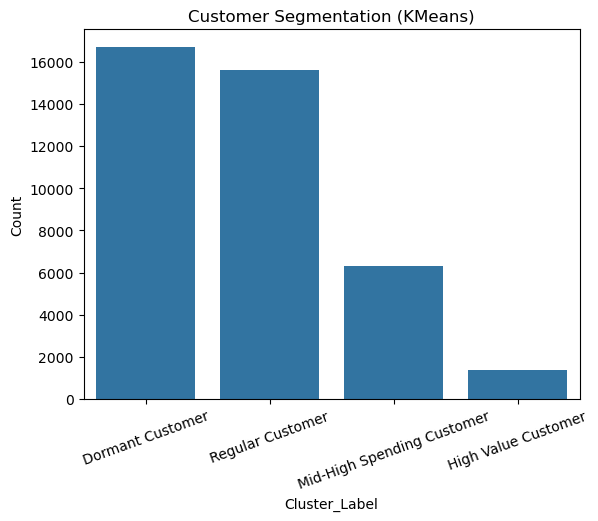

In [80]:
sns.countplot(data=rfm_clean, x='Cluster_Label', order=rfm_clean['Cluster_Label'].value_counts().index)
plt.title("Customer Segmentation (KMeans)")
plt.xticks(rotation=20)
plt.ylabel("Count")
plt.show()

## Results

| Cluster Label             | Characteristics                                | Strategy Suggestion              |
|---------------------------|------------------------------------------------|----------------------------------|
| High Value Customer       | Spends a lot, needs retention strategy         | VIP programs / loyalty rewards   |
| Mid-High Spending Customer| Infrequent but valuable                        | Encourage reactivation           |
| Regular Customer          | Average spending and recency                   | Incentivize further purchases    |
| Dormant Customer          | Inactive and low value                         | Optional targeting or ignore     |

### Observational Summary:
- Dormant customers account for the largest proportion, indicating a significant customer churn issue. These users are ideal candidates for reactivation strategies.

- Regular customers also make up a substantial portion, representing the core customer base and the primary target for general marketing initiatives.

- High-spending customers (including both Mid-High and High Value) are fewer in number but hold enormous revenue potential.

- The overall distribution is skewed, which aligns with the Pareto principle (80/20 rule) — a small group of customers contributes to the majority of profit.

### Strategic Implications:
- Dormant Customers
→ May be ignored in ongoing campaigns or targeted with a one-time revival effort, such as flash discounts or limited-time offers.

- Regular Customers
→ Represent an opportunity for growth. Consider applying loyalty programs, personalized recommendations, or targeted promotions to boost purchase frequency and order value.

- Mid-High Spending Customers
→ These customers spend a lot but are not very active. Focus on retention efforts, such as exclusive member benefits or reactivation campaigns to extend their lifecycle.

- High Value Customers
→ Should be offered VIP-tier services or premium benefits to maximize Customer Lifetime Value (CLV) and secure long-term loyalty.


## Output

-  `high_value_customers.csv`: List of top-tier customers for marketing use
-  Visualizations: RFM scores, cluster sizes, scatter plots

## Data Source (APA Citation)

Khanh Lai. (2023). *Mini Project - Data Analytics with SQL and Python* [Dataset]. Kaggle. https://www.kaggle.com/code/khanhlai03/mini-project-data-analytics-with-sql-and-python

Note: This dataset is intended for educational and analytical purposes.